In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import matplotlib
import pandas as pd
from datetime import date
import seaborn as sns
import dill

In [51]:
EXTRA_SMALL_SIZE = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

In [52]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = 2.5

In [53]:
#https://www.transtats.bts.gov/Data_Elements.aspx?Data=5
DOMESTIC_AVG_FLIGHT_CAP = 811547169 / 8596402 / 0.8510
INTERNATIONAL_AVG_FLIGHT_CAP = 241158082 / 1624127 / 0.8268
print(INTERNATIONAL_AVG_FLIGHT_CAP)
print(DOMESTIC_AVG_FLIGHT_CAP)
DOMESTIC_LOAD_FACTOR = np.multiply([79.56, 80.79, 50.07, 13.12, 38.95, 38.95, 38.95, 38.95, 38.95], 0.01)
INTERNATIONAL_LOAD_FACTOR = np.multiply([81.43, 74.37, 56.99, 28.30, 24.62, 24.62, 24.62, 24.62, 24.62], 0.01)
print(DOMESTIC_LOAD_FACTOR)
print(INTERNATIONAL_LOAD_FACTOR)

179.5896759939039
110.9347197273336
[0.7956 0.8079 0.5007 0.1312 0.3895 0.3895 0.3895 0.3895 0.3895]
[0.8143 0.7437 0.5699 0.283  0.2462 0.2462 0.2462 0.2462 0.2462]


In [54]:
GAMMA = 1/14
SIGMA = 1/5
PERC_EXPOSED = 0.1
STRENGTHS = np.arange(0.25, 1.01, 0.25)
TARGET = "Ontario"
TOTAL_MONTH = 8

In [55]:
MAX_DATE = np.datetime64('2020-08-31')

In [56]:
PROVINCES = ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Northwest Territories', 'Yukon', 'Nunavut']

In [57]:
MOVING_AVG_FILTER = np.ones((7,))/7

In [58]:
INSPECT_FLIGHTS = 3
INSPECT_MOBILITY = 1
INSPECT_EXPOSED = 2

In [59]:
#https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2310000801
def get_groundtruth_flights():
    airports = 'Total, all airports' if TARGET == "Canada" else TARGET
    flights = np.zeros(shape=(TOTAL_MONTH, 2))
    df_stacan = pd.read_csv("../../datasets/reported_flights_stats.csv", usecols=['REF_DATE', 'Airports', 'Domestic and international itinerant movements', 'VALUE'])
    df_stacan = df_stacan[df_stacan['Airports'].str.contains(airports)]
    df_stacan = df_stacan.groupby(['REF_DATE', 'Domestic and international itinerant movements']).sum()
    for m_idx, month in enumerate(df_stacan.index.get_level_values(0).unique()):
        flights[m_idx][0] = df_stacan.loc[month, 'Domestic movements']
        flights[m_idx][1] = df_stacan.loc[month, 'Other international movements'] + df_stacan.loc[month, 'Transborder movements']
    for month in np.arange(6, 8):
        flights[month] = flights[5]
    return flights.transpose()


groundtruth_flights = get_groundtruth_flights()
groundtruth_flights

array([[42987., 44068., 36304., 10426., 12787., 19961., 19961., 19961.],
       [25860., 24319., 20366.,  2824.,  3083.,  3551.,  3551.,  3551.]])

In [60]:
#https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
df_pop = pd.read_csv('../../datasets/canada_population_by_prov.csv', usecols=['GEO', 'VALUE'])
n = df_pop[df_pop['GEO'] == TARGET]['VALUE'].iloc[0]
df_pop

,GEO,VALUE
0,Canada,37894799
1,Newfoundland and Labrador,521365
2,Prince Edward Island,158158
3,Nova Scotia,977457
4,New Brunswick,779993
5,Quebec,8537674
6,Ontario,14711827
7,Manitoba,1377517
8,Saskatchewan,1181666
9,Alberta,4413146


In [61]:
df_covid = pd.read_csv('../../datasets/can_covid19.csv', usecols=['prname', 'date', 'numconf', 'numprob', 'numdeaths', 'numtotal', 'numrecover', 'numactive'])
df_covid['date'] = pd.to_datetime(df_covid['date'], format='%d-%m-%Y')
df_covid['i'] = df_covid['numactive'] / n
df_covid['r'] = (df_covid['numdeaths'] + df_covid['numrecover']) / n
df_covid = df_covid[df_covid['prname'].isin(PROVINCES)]
# df_covid[df_covid['numconf'] + df_covid['numprob'] != df_covid['numtotal']]
# df_covid[df_covid['numconf'] + df_covid['numprob'] - df_covid['numrecover'] - df_covid['numdeaths']!= df_covid['numactive']]
df_covid[df_covid['prname'] == TARGET]

,prname,date,numconf,numprob,numdeaths,numtotal,numrecover,numactive,i,r
0,Ontario,2020-01-31,3,0,0.0,3,NaN,3.0,2.039176e-07,NaN
3,Ontario,2020-02-08,3,0,0.0,3,NaN,3.0,2.039176e-07,NaN
6,Ontario,2020-02-16,3,0,0.0,3,NaN,3.0,2.039176e-07,NaN
9,Ontario,2020-02-21,3,0,0.0,3,NaN,3.0,2.039176e-07,NaN
12,Ontario,2020-02-24,4,0,0.0,4,NaN,4.0,2.718901e-07,NaN
...,...,...,...,...,...,...,...,...,...,...
2776,Ontario,2020-09-08,43536,0,2813.0,43536,39196.0,1527.0,1.037940e-04,0.002855
2791,Ontario,2020-09-09,43685,0,2813.0,43685,39332.0,1540.0,1.046777e-04,0.002865
2806,Ontario,2020-09-10,43855,0,2814.0,43855,39474.0,1567.0,1.065129e-04,0.002874
2821,Ontario,2020-09-11,44068,0,2813.0,44068,39598.0,1657.0,1.126305e-04,0.002883


In [62]:
# See fetch_historic_flights.py -> construct_edge_list.py -> process_flights_data.py
flights_filename = 'edge_list_processed_all-Canada.txt' if TARGET == 'Canada' else 'edge_list_processed-Canada.txt'
df_flights = pd.read_csv('../../datasets/edge_lists/%s' % flights_filename, names=['date', 'From', 'To', 'number of flights'])
df_flights['date'] = pd.to_datetime(df_flights['date'])
df_flights

,date,From,To,number of flights
0,2020-01-02,Ontario,Ontario,261
1,2020-01-02,US,Manitoba,8
2,2020-01-02,Ontario,China,6
3,2020-01-02,China,China,4
4,2020-01-02,Quebec,Quebec,140
...,...,...,...,...
45585,2020-09-12,Newfoundland and Labrador,Greenland,1
45586,2020-09-12,US,Newfoundland and Labrador,1
45587,2020-09-12,British Columbia,Mexico,1
45588,2020-09-12,France,Quebec,1


In [63]:
df_positive_rates = pd.read_csv('../../datasets/interpolated_positive_rates.csv', index_col=0)

In [64]:
def to_idx(start, end):
    return (end - start).days

In [65]:
def to_plt_date(d):
    return matplotlib.dates.date2num(date.fromisoformat(d))

In [66]:
def get_matrix_by_month(dates, m):
    m_by_month = np.zeros(dates.max().month)
    for date_idx, date in enumerate(dates):
        m_by_month[date.month - 1] += np.sum(m[date_idx])
    return m_by_month

In [67]:
def plot_flights(dates, x, title, ylabel, filename=None):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    plt_dates = matplotlib.dates.date2num(dates.to_pydatetime())
    ax.plot_date(plt_dates, gaussian_filter1d(np.sum(x, axis=1), sigma=2), '-', label="Total")
    if TARGET in PROVINCES:
        ax.plot_date(plt_dates, gaussian_filter1d(np.sum(x[:, data.domestic_indices], axis=1), sigma=2), '-', label="domestic")
        ax.plot_date(plt_dates, gaussian_filter1d(np.sum(x[:, data.international_indices], axis=1), sigma=2), '-', label="international")
    ax.set_xlabel('Dates')
    ax.set_ylabel(ylabel)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 7))
    ax.xaxis.set_tick_params(rotation=30)
    legend = ax.legend()
    plt.axvline(x= to_plt_date('2020-03-14'), ls='--', label='Ban all non-essential travel', c='r')
    plt.axvline(x=to_plt_date('2020-03-18'), ls='--', label='Border closure for countries other than US', c='purple')
    plt.axvline(x=to_plt_date('2020-03-20'), ls='--', label='US border closure', c='black')
    plt.legend()
#     plt.title(title)
    if filename:
        plt.savefig('../../graphs/flights/%s' % filename, bbox_inches='tight')

In [68]:
def format_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


def plot_top_countries_by_date(f, date, k, title, data):
    date_idx = to_idx(data.dates[0], date)
    k = min(len(f[date_idx]), k)
    top_country_idx = np.argpartition(f[date_idx], -k)[-k:]
    x = f[date_idx, top_country_idx]
    y = data.nodes[top_country_idx]
    blues = sns.color_palette("Blues")
    greens = sns.color_palette("Greens")
    colors = []
    for country_idx in top_country_idx:
        if data.nodes[country_idx] in PROVINCES:
            colors.append(blues[country_idx % len(blues)])
        else:
            colors.append(greens[country_idx % len(greens)])
    x = np.append(x, np.sum(np.delete(f[date_idx], top_country_idx)))
    y = np.append(y, 'Other')
    colors.append(greens[country_idx % len(greens)])
    fig = plt.figure(facecolor='w', figsize=(12, 8))
    ax = fig.add_subplot(111)
    ax.pie(x, labels=y, autopct=format_autopct(x), colors=colors)
    plt.title(title)

In [69]:
def plot_interpolation(x, y, pred_x, pred_y, title, ylabel):
    fig = plt.figure(facecolor='w', figsize=(16, 8))
    ax = fig.add_subplot(111)
    ax.plot_date(matplotlib.dates.date2num(x.to_pydatetime()), y, 'o', label='data')
    ax.plot_date(matplotlib.dates.date2num(pred_x.to_pydatetime()), pred_y, '-', label='predicted')
    ax.set_xlabel('Dates')
    ax.set_ylabel(ylabel)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 7))
    ax.xaxis.set_tick_params(rotation=30)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 7))
    ax.xaxis.set_tick_params(rotation=30)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(title)

In [70]:
class Data:
    
    def __init__(self, target):
        self.target = target
        self.pos_rate = None
        self.domestic_load_factor = None
        self.international_load_factor = None
        
        self.dates = self. __get_dates()
        self.df_target = self.__get_df_target()
        self.min_t = self.dates.dayofyear[0]
        self.max_t = self.dates.dayofyear[-1]
        self.nodes = self.__get_nodes()
        self.domestic_indices = np.where(self.nodes == self.target)[0] if TARGET == 'Canada' else np.where(np.isin(self.nodes, PROVINCES))[0]
        self.international_indices = np.where(self.nodes != self.target)[0] if TARGET == 'Canada' else np.where(np.isin(self.nodes, PROVINCES, invert=True))[0]
        self.n = df_pop[df_pop['GEO'] == TARGET]['VALUE'].iloc[0]
        self.target_idx = np.where(self.nodes == self.target)[0][0]
        self.pos_rate = self.__get_positive_rates() 
        
        self.exp_in = None
        self.exp_out = None
        self.f_in = None
        self.f_out = None
        
    def __get_df_target(self):
        df_target = None
        if self.target in PROVINCES:
            df_target = df_covid[df_covid['prname'] == self.target]
            df_target = df_target.set_index('date')
        else:
            df_target = df_covid.groupby('date').sum()
        dates = self.dates[~self.dates.isin(df_target.index.unique())] 
        df_pre = pd.DataFrame(index=pd.Index(dates, name='date'), columns=['numconf', 'numprob', 'numdeaths', 'numtotal', 'numrecover', 'numactive']) 
        df_target = df_pre.append(df_target)
        df_target = df_target.fillna(0)
        print(df_target)
        return df_target
        
        
    def __get_dates(self):
        dates = df_flights[df_flights['date'] <= MAX_DATE]['date']
        dates = pd.to_datetime(sorted(dates.unique()))
        print("date range: %s to %s" % (dates[0], dates[-1]))
        return dates
    
    
    def __get_nodes(self):
        nodes = df_flights[(df_flights['From'] == self.target) | (df_flights['To'] == self.target)]
        nodes = pd.concat([nodes['From'], nodes['To']]).unique()
        print("nodes", nodes)
        return nodes
    
    
    #Assumption: if the positive rate of a country is unknown, use the average positive rate
    def __get_positive_rates(self):
        df_rates = df_positive_rates[pd.to_datetime(df_positive_rates.index).isin(self.dates)]
        rates = np.zeros(shape=(len(self.nodes), len(self.dates)))
        for n_idx, node in enumerate(self.nodes): 
            if node in df_rates.columns:
                rates[n_idx] = df_rates[node]
            else:
                rates[n_idx] = df_rates['Average']
        return np.transpose(rates)
    
    
    def save_to_file(self):
        data_file_path = '../../states/%s_data.pkl' % (TARGET)
        with open(data_file_path, "wb") as data_file:
            dill.dump(self, data_file)

In [71]:
data = Data(TARGET)

date range: 2020-01-02 00:00:00 to 2020-08-31 00:00:00
            numconf  numprob  numdeaths  numtotal  numrecover  numactive  \
date                                                                       
2020-01-02        0        0        0.0         0         0.0        0.0   
2020-01-03        0        0        0.0         0         0.0        0.0   
2020-01-04        0        0        0.0         0         0.0        0.0   
2020-01-05        0        0        0.0         0         0.0        0.0   
2020-01-06        0        0        0.0         0         0.0        0.0   
...             ...      ...        ...       ...         ...        ...   
2020-09-08    43536        0     2813.0     43536     39196.0     1527.0   
2020-09-09    43685        0     2813.0     43685     39332.0     1540.0   
2020-09-10    43855        0     2814.0     43855     39474.0     1567.0   
2020-09-11    44068        0     2813.0     44068     39598.0     1657.0   
2020-09-12    44300        0     

In [72]:
def get_country_indices(policy, target, scope='all'):
    if policy == 'World':
        isPolicy = data.nodes != policy if target else data.nodes == policy
    else:
        isPolicy = data.nodes == policy if target else data.nodes != policy
    isDomestic = data.nodes == TARGET if TARGET == 'Canada' else np.isin(data.nodes, PROVINCES)
    if scope == 'all':
        return np.where(isPolicy)[0]
    elif scope == 'domestic':
        return np.where(isPolicy & isDomestic)[0]
    else:
        return np.where(isPolicy & ~isDomestic)[0]

In [73]:
def plot_load_factor(x_actual, actual_lf_domestic, actual_lf_international, x_pred, pred_lf1_domestic, pred_lf1_international):
    fig = plt.figure(facecolor='w', figsize=(16, 8))
    ax = fig.add_subplot(111)
    ax.scatter(matplotlib.dates.date2num(x_actual.to_pydatetime()), actual_lf_domestic, c='green', s=75)
    ax.scatter(matplotlib.dates.date2num(x_actual.to_pydatetime()), actual_lf_international, c='red', s=75)
    ax.plot_date(matplotlib.dates.date2num(x_pred.to_pydatetime()), pred_lf1_domestic, '--', label='domestic load factor', c='green')
    ax.plot_date(matplotlib.dates.date2num(x_pred.to_pydatetime()), pred_lf1_international, '--', label='international load factor', c='red')
    ax.set_xlabel('Date')
    ax.set_ylabel('Load Factor')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=30)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=30)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
#     plt.title('Interpolated Domestic and International Load Factor')
    plt.savefig('../../graphs/flights/load_factor.png', bbox_inches='tight')

In [74]:
def get_load_factor():
    lf_date_range = pd.date_range(start="2020-01-01",end="2020-10-01", periods=9)
    x_pred = pd.date_range(start="2020-01-01",end="2020-10-01")
    f_domesetic = interp1d(lf_date_range.dayofyear, DOMESTIC_LOAD_FACTOR, kind='linear')
    f_international = interp1d(lf_date_range.dayofyear, INTERNATIONAL_LOAD_FACTOR, kind='linear')
    pred_lf_domestic = f_domesetic(x_pred.dayofyear)
    pred_lf_international = f_international(x_pred.dayofyear)
    pred_lf1_domestic = [i for i in pred_lf_domestic]
    actual_lf_domestic = [i for i in DOMESTIC_LOAD_FACTOR]
    pred_lf1_international = [i for i in pred_lf_international]
    actual_lf_international = [i for i in INTERNATIONAL_LOAD_FACTOR]
    plot_load_factor(lf_date_range, actual_lf_domestic, actual_lf_international, x_pred, pred_lf1_domestic, pred_lf1_international)
    return pred_lf_domestic, pred_lf_international

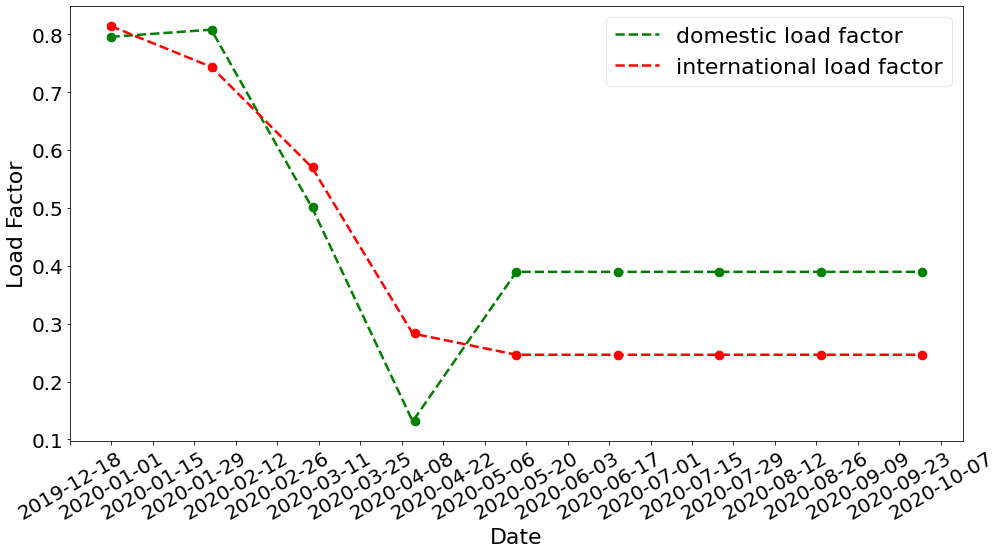

In [75]:
data.domestic_load_factor, data.international_load_factor = get_load_factor()

In [76]:
def get_flights_for_date(date):
    df = df_flights[df_flights['date'] == date]
    f_in = np.zeros(len(data.nodes))
    f_out = np.zeros(len(data.nodes))
    for idx, row in df.iterrows():
        if row['From'] == data.target and row['To'] == data.target:
            continue
        elif row['From'] == data.target:
            to_idx = np.where(data.nodes == row['To'])[0][0]
            f_out[to_idx] += row['number of flights']
        elif row['To'] == data.target:
            from_idx = np.where(data.nodes == row['From'])[0][0]
            f_in[from_idx] += row['number of flights']
        else:
            continue
    return f_in, f_out


def get_flights(dates):
    f_in = np.zeros((len(dates), len(data.nodes)))
    f_out = np.zeros((len(dates), len(data.nodes)))
    for date_idx, date in enumerate(dates):
        f_in[date_idx], f_out[date_idx] = get_flights_for_date(date)
    scale_flights(f_in, f_out, dates)
    return f_in, f_out
    
        
def scale_flights(f_in, f_out, dates):
    international_in_actual = get_matrix_by_month(dates, f_in[:, data.international_indices])
    international_out_actual = get_matrix_by_month(dates, f_out[:, data.international_indices])
    domestic_in_actual = get_matrix_by_month(dates, f_in[:, data.domestic_indices])
    domestic_out_actual = get_matrix_by_month(dates, f_out[:, data.domestic_indices])
    for date_idx, date in enumerate(dates):
        m = date.month - 1
        if m >= TOTAL_MONTH:
            break
        in_scale = groundtruth_flights[1, m] / 2 / international_in_actual[m]
        out_scale = groundtruth_flights[1, m] / 2 / international_out_actual[m]
        din_scale = groundtruth_flights[0, m] / 2 / domestic_in_actual[m] if domestic_in_actual[m] > 0 else 0
        dout_scale = groundtruth_flights[0, m] / 2 / domestic_out_actual[m] if domestic_out_actual[m] > 0 else 0
        f_in[date_idx, data.international_indices] = f_in[date_idx, data.international_indices] * in_scale
        f_out[date_idx, data.international_indices] = f_out[date_idx, data.international_indices] * out_scale
        f_in[date_idx, data.domestic_indices] = f_in[date_idx, data.domestic_indices] * din_scale
        f_out[date_idx, data.domestic_indices] = f_out[date_idx, data.domestic_indices] * dout_scale

In [77]:
def inspect_flights_data(f_in, f_out, dates, strength=None):
    suffix = "" if strength is None else ", Repoen {:.2f}%".format(strength * 100)
    if INSPECT_FLIGHTS > 2:
        plot_top_countries_by_date(f_in + f_out, np.datetime64('2020-01-15'), 10, "top 10 origin countries Jan 15%s" % suffix, data)
        plot_top_countries_by_date(f_in + f_out, np.datetime64('2020-04-15'), 10, "top 10 origin countries Apr 15%s" % suffix, data)
        plot_top_countries_by_date(f_in + f_out, np.datetime64('2020-08-15'), 10, "top 10 origin countries Aug 15%s" % suffix, data)
    if INSPECT_FLIGHTS > 1:
        plot_flights(dates, f_in, "Incoming International Flights vs Dates%s" % suffix, "Number of Flights")
        plot_flights(dates, f_out, "Outgoing International Flights vs Dates%s" % suffix, "Number of Flights")
    if INSPECT_FLIGHTS > 0:
        plot_flights(dates, f_in + f_out, "Total International Flights vs Dates%s" % suffix, "Number of Flights")
        print("total international reported", groundtruth_flights[1])
        print("scaled international flights", get_matrix_by_month(dates, f_in[:, data.international_indices] + f_out[:, data.international_indices]))
        print("total domestic reported", groundtruth_flights[0])
        print("scaled domestic flights", get_matrix_by_month(dates, f_in[:, data.domestic_indices] + f_out[:, data.domestic_indices]))

total international reported [25860. 24319. 20366.  2824.  3083.  3551.  3551.  3551.]
scaled international flights [25860. 24319. 20366.  2824.  3083.  3551.  3551.  3551.]
total domestic reported [42987. 44068. 36304. 10426. 12787. 19961. 19961. 19961.]
scaled domestic flights [42987. 44068. 36304. 10426. 12787. 19961. 19961. 19961.]


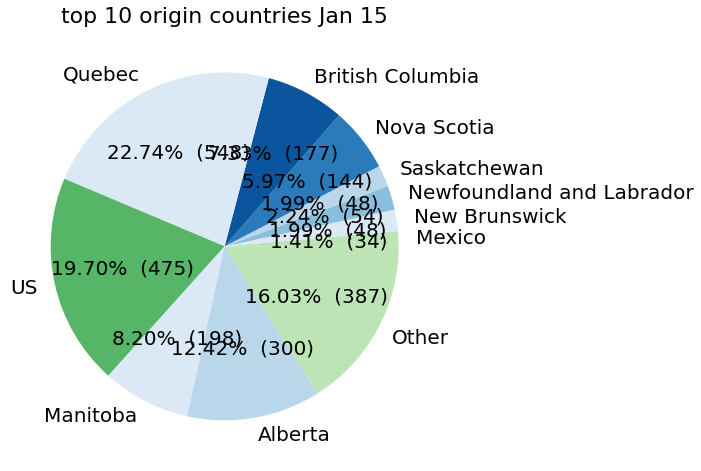

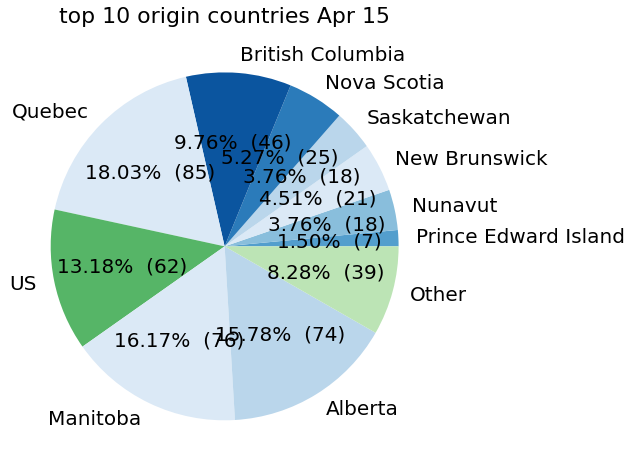

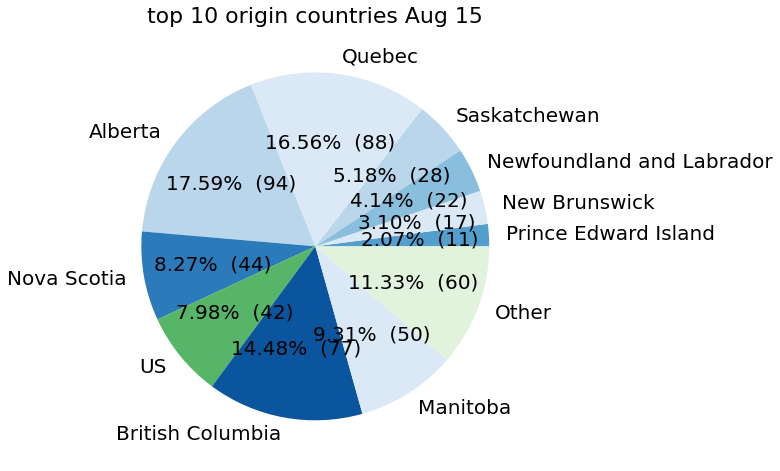

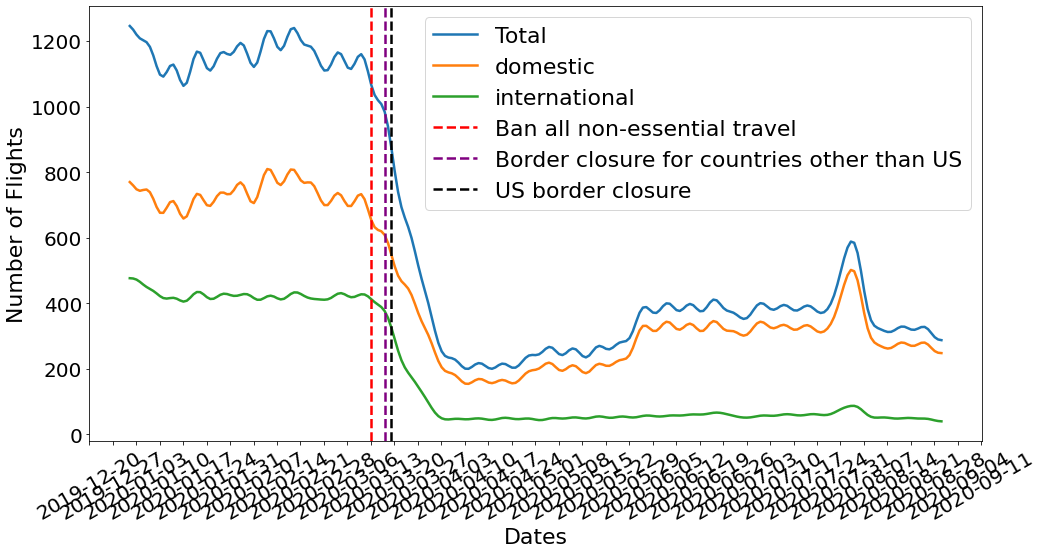

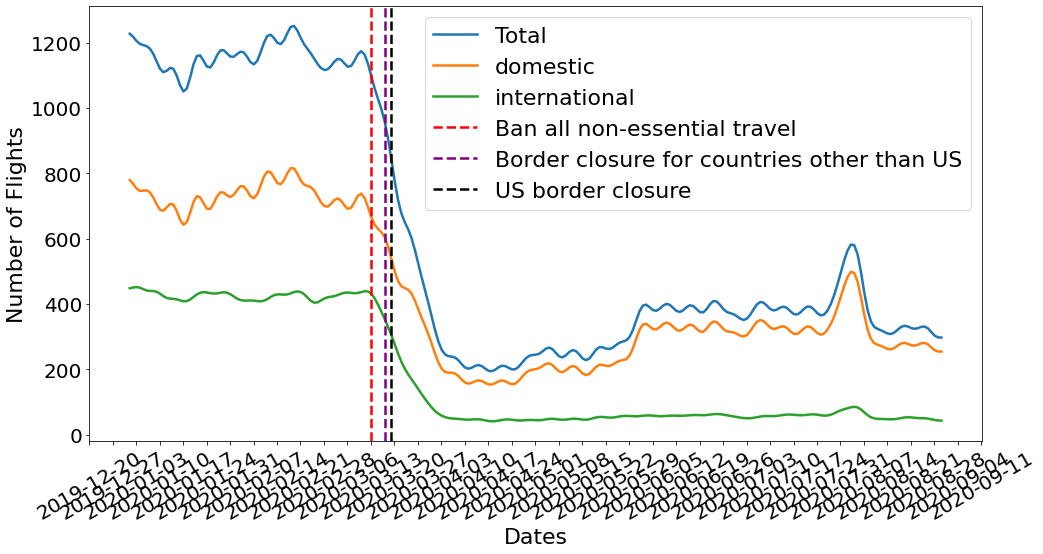

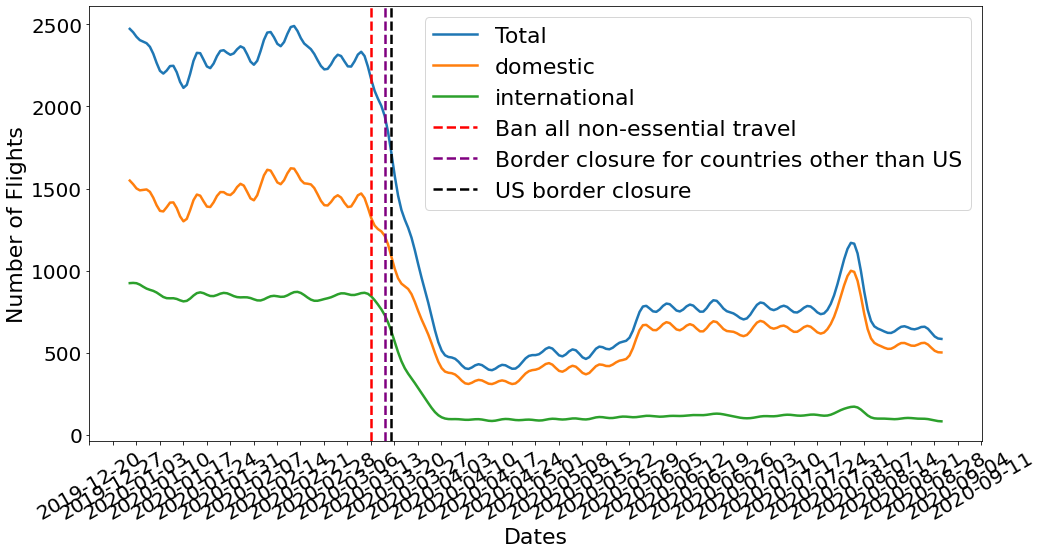

In [78]:
data.f_in, data.f_out = get_flights(data.dates)
inspect_flights_data(data.f_in, data.f_out, data.dates)

In [79]:
def estimate_mobility(f, international_load_factor, domestic_load_factor, dates, policy):
    international_target = get_country_indices(policy, target=True, scope='international')
    international_non_target = get_country_indices(policy, target=False, scope='international')
    domestic_target = get_country_indices(policy, target=True, scope='domestic')
    domestic_non_target = get_country_indices(policy, target=False, scope='domestic')
    m = np.zeros(shape=f.shape)
    for date_idx, date in enumerate(dates):
        if policy is None:
            m[date_idx, data.international_indices] = f[date_idx, data.international_indices] * international_load_factor[date_idx] * INTERNATIONAL_AVG_FLIGHT_CAP
            m[date_idx, data.domestic_indices] = f[date_idx, data.domestic_indices] * domestic_load_factor[date_idx] * DOMESTIC_AVG_FLIGHT_CAP
        else:
            m[date_idx, international_target] = f[date_idx, international_target] * international_load_factor[date_idx, 0] * INTERNATIONAL_AVG_FLIGHT_CAP
            m[date_idx, international_non_target] = f[date_idx, international_non_target] * international_load_factor[date_idx, 1] * INTERNATIONAL_AVG_FLIGHT_CAP
            m[date_idx, domestic_target] = f[date_idx, domestic_target] * domestic_load_factor[date_idx, 0] * DOMESTIC_AVG_FLIGHT_CAP
            m[date_idx, domestic_non_target] = f[date_idx, domestic_non_target] * domestic_load_factor[date_idx, 1] * DOMESTIC_AVG_FLIGHT_CAP
    return m

In [80]:
def inspect_mobility(m_in, m_out, dates, strength=None):
    suffix = "" if strength is None else ", Repoen {:.2f}%".format(strength * 100)
    if INSPECT_MOBILITY > 0:
        plot_flights(dates, m_in, "Incoming Population%s" % suffix, "Population")
        plot_flights(dates, m_out, "Outgoing Population%s" % suffix, "Population")
        print("estimated international inflow", get_matrix_by_month(dates, m_in))

In [81]:
def interpolate_exp_population(dates, e, direction):
    x = dates.dayofyear
    y = np.sum(e, axis=1)
    f = interp1d(x, y, kind='cubic')
#     plot_interpolation(dates, y, dates, f(x), "interpolated exposed %s population" % direction, "population")
    return f

In [82]:
def plot_exposed(dates, e_in, e_out):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    plt_dates = matplotlib.dates.date2num(dates.to_pydatetime())
    ax.plot_date(plt_dates, gaussian_filter1d(np.sum(e_in, axis=1), sigma=2), '-', label="Incoming Exposed")
    ax.plot_date(plt_dates, gaussian_filter1d(np.sum(e_out, axis=1), sigma=2), '-', label="Outgoing Exposed")
    ax.plot_date(plt_dates, gaussian_filter1d(np.sum(e_in - e_out, axis=1), sigma=2), '-', label="Net Exposed")
    if TARGET in PROVINCES:
        ax.plot_date(plt_dates, gaussian_filter1d(np.sum(e_in[:, data.domestic_indices], axis=1), sigma=2), '-', label="Domestic Incoming Exposed")
        ax.plot_date(plt_dates, gaussian_filter1d(np.sum(e_in[:, data.international_indices], axis=1), sigma=2), '-', label="International Incoming Exposed")
        ax.plot_date(plt_dates, gaussian_filter1d(np.sum(e_out[:, data.domestic_indices], axis=1), sigma=2), '-', label="Domestic Outgoing Exposed")
        ax.plot_date(plt_dates, gaussian_filter1d(np.sum(e_out[:, data.international_indices], axis=1), sigma=2), '-', label="International Outgoing Exposed")
    ax.set_xlabel('Date')
    ax.set_ylabel('Population')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=30)
    legend = ax.legend()
    plt.axvline(x= to_plt_date('2020-03-14'), ls='--', label='Ban all non-essential travel', c='r')
    plt.axvline(x=to_plt_date('2020-03-18'), ls='--', label='Border closure for countries other than US', c='purple')
    plt.axvline(x=to_plt_date('2020-03-20'), ls='--', label='US border closure', c='black')
    plt.legend()
    plt.savefig('../../graphs/flights/%s' % "%s_exposed_estimate.png" % TARGET, bbox_inches='tight')

In [83]:
def inspect_exposed(e_in, e_out, dates, strength=None):
    if INSPECT_EXPOSED > 0:
        if strength is None:
            plot_exposed(dates, e_in, e_out)
        else:
            plot_flights(dates, e_in - e_out, "Net Exposed Population, Repoen {:.2f}%".format(strength * 100), "Population")

In [84]:
def estimate_exposed(m_in, m_out, pos_rate, dates):
    e_in = np.zeros(shape=m_in.shape)
    e_out = np.zeros(shape=m_out.shape)
    for date_idx, date in enumerate(dates):
        for n_idx, node in enumerate(data.nodes): 
            e_in[date_idx][n_idx] = m_in[date_idx][n_idx] * (pos_rate[date_idx][n_idx] * PERC_EXPOSED)
            e_out[date_idx][n_idx] = m_out[date_idx][n_idx] * (pos_rate[date_idx][data.target_idx] * PERC_EXPOSED)
    return e_in, e_out

In [85]:
def flight_to_exposed(f_in, f_out, international_load_factor, domestic_load_factor, pos_rate, dates, strength=None, policy=None):
    m_in = estimate_mobility(f_in, international_load_factor, domestic_load_factor, dates, policy)
    m_out = estimate_mobility(f_out, international_load_factor, domestic_load_factor, dates, policy)
    inspect_mobility(m_in, m_out, dates, strength)
    e_in, e_out = estimate_exposed(m_in, m_out, pos_rate, dates)
    inspect_exposed(e_in, e_out, dates, strength)
    f_exp_in = interpolate_exp_population(dates, e_in, "inflow")
    f_exp_out = interpolate_exp_population(dates, e_out, "outflow")
    return e_in, e_out, f_exp_in, f_exp_out

estimated international inflow [3731613.7360146  3255162.17312197 1895659.99571122  191720.64029753
  319842.24568441  509751.85025479  509751.85025479  509751.85025479]


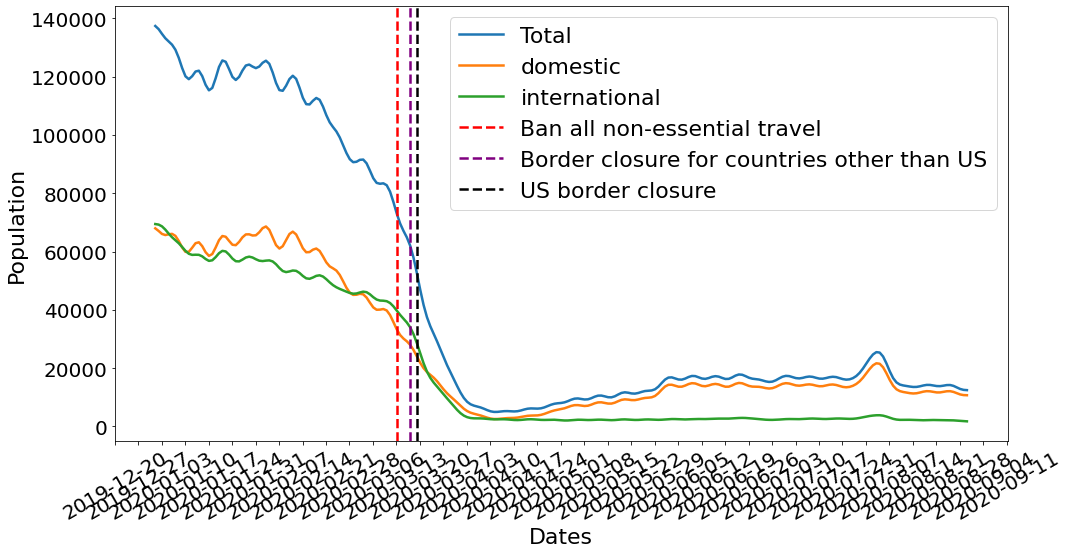

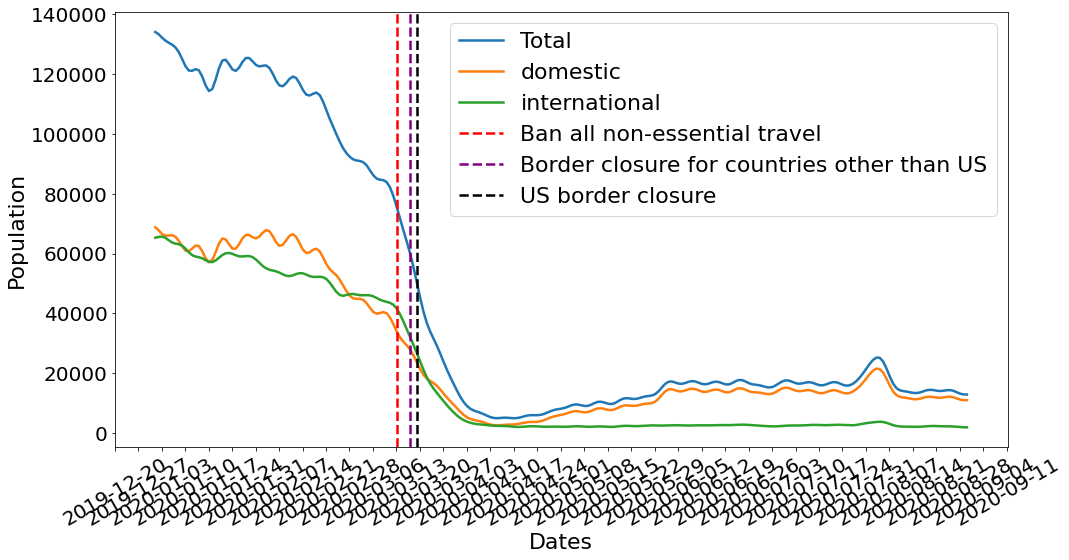

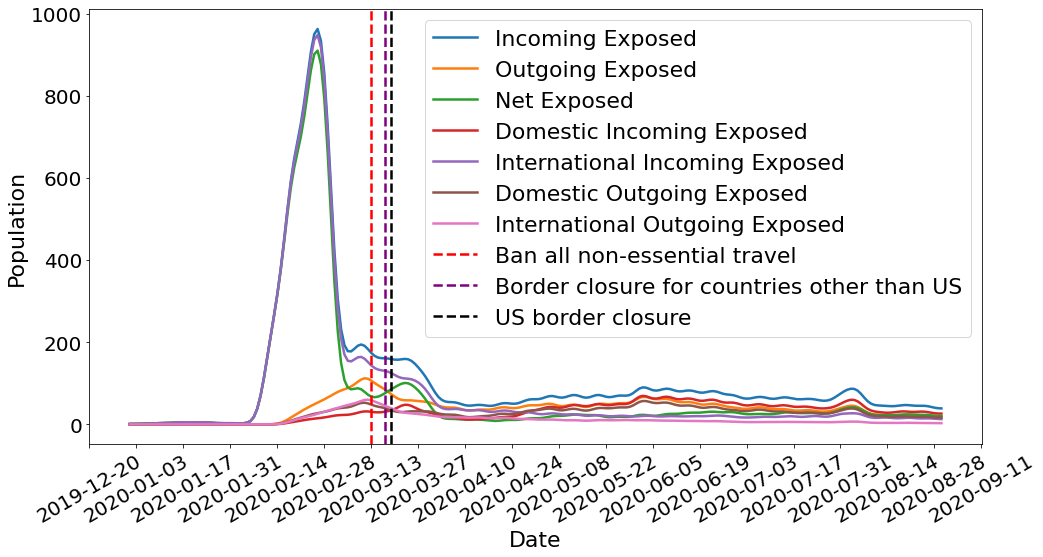

In [86]:
data.e_in, data.e_out, data.exp_in, data.exp_out = flight_to_exposed(data.f_in, data.f_out, data.international_load_factor, data.domestic_load_factor, data.pos_rate, data.dates)

In [87]:
def get_indices_by_month(target_month, dates):
    indices = []
    for date_idx, date in enumerate(dates):
        if(date.month == target_month):
            indices.append(date_idx)
    return indices

In [88]:
def mock_flights(f, reopen_idx, policy, strength, dates):     
    real_end_idx = len(data.dates)
    mock_end_idx = len(dates)
    target_indices = get_country_indices(policy, target=True)
    non_target_indices = get_country_indices(policy, target=False)
    jan_indices = get_indices_by_month(1, data.dates)
    last_month_indices = get_indices_by_month(TOTAL_MONTH, data.dates)
    #            start --- reopen --- real_end --- mock_end
    # target           f          0             0            
    # non_target       f          f             0      
    reopen = np.zeros((len(dates), len(data.nodes)))
    reopen[:real_end_idx, :] = f[:real_end_idx]
    reopen[reopen_idx:, target_indices] = 0
    #            start --- reopen --- real_end --- mock_end
    # target           f          m1            m1            
    # non_target       f          f             0           
    for i in target_indices:
        daily_count = np.mean(f[jan_indices, i])
        total_count = daily_count * (mock_end_idx - reopen_idx) * strength
        dates = np.random.choice(np.arange(reopen_idx, mock_end_idx), int(total_count))
        for date in dates:
            reopen[date, i] += 1
    #            start --- reopen --- real_end --- mock_end
    # target           f          m1            m1            
    # non_target       f          f             m2      
    if mock_end_idx - real_end_idx > 0:
        for i in non_target_indices:
            daily_count = np.mean(f[last_month_indices, i])
            total_count = daily_count * (mock_end_idx - real_end_idx) * strength
            dates = np.random.choice(np.arange(real_end_idx, mock_end_idx), int(total_count))
            for date in dates:
                reopen[date, i] += 1
    return reopen

In [89]:
def mock_load_factor(real_load_factor, reopen_idx, strength, dates):
    real_end_idx = len(data.dates)
    mock_end_idx = len(dates)
    load_factor = np.zeros(shape=(len(dates), 2))
    # target
    load_factor[:reopen_idx, 0] = real_load_factor[:reopen_idx]
    load_factor[reopen_idx:, 0] = [real_load_factor[0] * strength] * (mock_end_idx - reopen_idx)
    # non_target
    load_factor[:real_end_idx, 1] = real_load_factor[:real_end_idx]
    load_factor[real_end_idx:, 1] = [real_load_factor[-1]] * (mock_end_idx - real_end_idx)
    return load_factor

In [90]:
def mock_pos_rate(dates):
    pos_rate = np.zeros(shape=(len(dates), len(data.nodes)))
    real_end_idx = len(data.dates)
    mock_end_idx = len(dates)
    pos_rate[:real_end_idx] = data.pos_rate[:real_end_idx]
    avg_pos_rates = np.mean(data.pos_rate[-7:, :], axis=0)
    if mock_end_idx - real_end_idx > 0:
        pos_rate[real_end_idx:,] = np.transpose(np.repeat(avg_pos_rates.reshape((-1, 1)), mock_end_idx - real_end_idx, axis=1))
#     plot_flights(dates, pos_rate[:, [1]], "US Mock Positive Rates vs Dates%s", "Percentage")
#     plot_flights(dates, pos_rate[:, [0]], "Canada Mock Positive Rates vs Dates%s", "Percentage")
    return pos_rate

In [91]:
def mock_exposed(reopen_date, strength, policy, dates):
    reopen_idx = to_idx(dates[0], reopen_date)
    f_in = mock_flights(data.f_in, reopen_idx, policy, strength, dates)
    f_out = mock_flights(data.f_out, reopen_idx, policy, strength, dates)
    inspect_flights_data(f_in, f_out, dates, strength=strength)
    international_load_factor = mock_load_factor(data.international_load_factor, reopen_idx, strength, dates)
    domestic_load_factor = mock_load_factor(data.domestic_load_factor, reopen_idx, strength, dates)
    pos_rate = mock_pos_rate(dates)
    return flight_to_exposed(f_in, f_out, international_load_factor, domestic_load_factor, pos_rate, dates, strength, policy)

In [92]:
class EarlyTimeMocks:
    
    def __init__(self, target):
        self.target = target
        self.exposed_in = None
        self.exposed_out = None
        
    def generate_mock_exposed_data(self):
        reopen_date = np.datetime64('2020-01-03')
        _, _, self.exposed_in, self.exposed_out = mock_exposed(reopen_date, 1.0, 'World', data.dates)
        
    def save_to_file(self):
        file_path = '../../states/%s_early_time.pkl' % (self.target)
        with open(file_path, "wb") as file:
            dill.dump(self, file)

In [93]:
class ReopenMocks:
    
    def __init__(self, target, reopen_date, dates, policy):
        self.target = target
        self.reopen_date = reopen_date
        self.dates = dates
        self.policy = policy
        self.exposed_in = None
        self.exposed_out = None
        
    def generate_mock_exposed_data(self):
        exposed_in = []
        exposed_out = []
        for idx, strength in enumerate(STRENGTHS):
            _, _, in_mock, out_mock = mock_exposed(self.reopen_date, strength, self.policy, self.dates)
            exposed_in.append(in_mock)
            exposed_out.append(out_mock)
        self.exposed_in = exposed_in
        self.exposed_out = exposed_out

        
    def save_to_file(self):
        file_path = '../../states/%s_reopen_%s_%s.pkl' % (self.target, self.reopen_date, self.policy)
        with open(file_path, "wb") as file:
            dill.dump(self, file)

In [94]:
data.save_to_file()

In [95]:
INSPECT_FLIGHTS = 0
INSPECT_MOBILITY = 0
INSPECT_EXPOSED = 0

In [96]:
early_time = EarlyTimeMocks(TARGET)
early_time.generate_mock_exposed_data()
early_time.save_to_file()

In [97]:
INSPECT_FLIGHTS = 0
INSPECT_MOBILITY = 0
INSPECT_EXPOSED = 0

In [98]:
reopen_date = np.datetime64('2020-08-01')
dates = pd.date_range(data.dates[0], np.datetime64('2020-12-31'))

reopen_world = ReopenMocks(TARGET, reopen_date, dates, 'World')
reopen_world.generate_mock_exposed_data()
reopen_world.save_to_file()

reopen_us = ReopenMocks(TARGET, reopen_date, dates, 'US')
reopen_us.generate_mock_exposed_data()
reopen_us.save_to_file()

reopen_china = ReopenMocks(TARGET, reopen_date, dates, 'United Kingdom')
reopen_china.generate_mock_exposed_data()
reopen_china.save_to_file()